# Problem Statement

### Credit Card Lead Prediction

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.


The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 


In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.


Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

    Customer details (gender, age, region etc.)
    Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier


from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

pd.options.display.max_columns = 200

In [2]:
data = pd.read_csv("train_s3TEQDk.csv")
test = pd.read_csv("test_mSzZ8RL.csv")
print(f"Train shape {data.shape}, Test Shape {test.shape}")

Train shape (245725, 11), Test Shape (105312, 10)


In [3]:
train,valid = train_test_split(data,test_size=0.20,random_state=345,stratify=data['Is_Lead'])
train = train.copy()
valid = valid.copy()
print(f"Train shape {train.shape} Validation shape {valid.shape}")

Train shape (196580, 11) Validation shape (49145, 11)


In [4]:
train.head(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
53078,N3ZQ84QR,Female,46,RG280,Self_Employed,X2,51,No,863584,Yes,0
213644,JWGAMK7P,Male,67,RG258,Other,X2,43,Yes,706126,No,0
131870,CX9NGNQT,Male,46,RG279,Self_Employed,X2,26,Yes,422207,Yes,0


In [5]:
test.head(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No


In [6]:
valid.head(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
148453,OK9KJGZ2,Female,55,RG268,Self_Employed,X1,37,No,929257,No,0
117997,TTC7CPSI,Male,57,RG283,Self_Employed,X3,87,NaN,909740,No,0
5432,MPUWVRAX,Male,39,RG275,Salaried,X1,8,Yes,961742,Yes,0


In [7]:
train['ID'].nunique()

196580

In [8]:
train.isna().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         23525
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [9]:
train['Gender'].value_counts(normalize=True)

Male      0.546693
Female    0.453307
Name: Gender, dtype: float64

In [10]:
train['Region_Code'].nunique()

35

In [11]:
train['Occupation'].value_counts(normalize=True)

Self_Employed    0.411532
Salaried         0.292731
Other            0.284866
Entrepreneur     0.010871
Name: Occupation, dtype: float64

In [12]:
train['Channel_Code'].value_counts(normalize=True)

X1    0.421279
X3    0.280359
X2    0.275669
X4    0.022693
Name: Channel_Code, dtype: float64

In [13]:
train['Credit_Product'].value_counts(normalize=True)

No     0.667019
Yes    0.332981
Name: Credit_Product, dtype: float64

In [14]:
train['Avg_Account_Balance'].describe()

count    1.965800e+05
mean     1.129489e+06
std      8.532486e+05
min      2.079000e+04
25%      6.042470e+05
50%      8.954865e+05
75%      1.368733e+06
max      1.035201e+07
Name: Avg_Account_Balance, dtype: float64

In [15]:
train['Is_Active'].value_counts(normalize=True)

No     0.611375
Yes    0.388625
Name: Is_Active, dtype: float64

In [16]:
train['Is_Lead'].value_counts(normalize=True)

0    0.762794
1    0.237206
Name: Is_Lead, dtype: float64

In [17]:
train['Age'].describe()

count    196580.000000
mean         43.864971
std          14.821238
min          23.000000
25%          30.000000
50%          43.000000
75%          54.000000
max          85.000000
Name: Age, dtype: float64

In [18]:
train['Vintage'].describe()

count    196580.000000
mean         46.978121
std          32.346981
min           7.000000
25%          20.000000
50%          32.000000
75%          73.000000
max         135.000000
Name: Vintage, dtype: float64

In [19]:
train.groupby(['Is_Lead'])[['Age','Avg_Account_Balance']].median()

,Age,Avg_Account_Balance
Is_Lead,,
0,38,871158
1,49,980686


<AxesSubplot:xlabel='Avg_Account_Balance'>

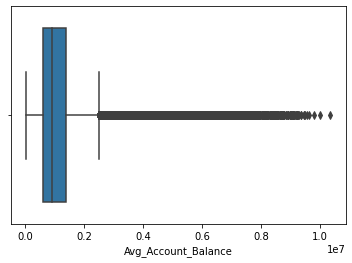

In [20]:
sns.boxplot(x = train['Avg_Account_Balance'])

In [21]:
iqr = train['Avg_Account_Balance'].quantile(0.75)-train['Avg_Account_Balance'].quantile(0.25)
iqr

764486.0

In [22]:
iqr = 1.5*iqr
iqr

1146729.0

In [23]:
train['balance_above_iqr'] = (train['Avg_Account_Balance'] >= iqr).astype(int)
test['balance_above_iqr'] = (test['Avg_Account_Balance'] >= iqr).astype(int)
valid['balance_above_iqr'] = (valid['Avg_Account_Balance'] >= iqr).astype(int)

In [24]:
train['Credit_Product'] = train['Credit_Product'].fillna('NA')
train['Avg_Account_Balance'] = np.log(1+train['Avg_Account_Balance'])

test['Credit_Product'] = test['Credit_Product'].fillna('NA')
test['Avg_Account_Balance'] = np.log(1+test['Avg_Account_Balance'])

valid['Credit_Product'] = valid['Credit_Product'].fillna('NA')
valid['Avg_Account_Balance'] = np.log(1+valid['Avg_Account_Balance'])


In [25]:
train.sample(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,balance_above_iqr
156925,Z5F95HCJ,Male,50,RG271,Self_Employed,X2,26,NA,13.500978,No,1,0
139516,9SSLSKEN,Male,54,RG268,Salaried,X2,91,Yes,14.024446,Yes,1,1
57810,2GEMZXBY,Male,57,RG261,Other,X2,110,NA,14.544781,Yes,1,1


In [26]:
train['Is_Active'] = train['Is_Active'].replace({'No':'N','Yes':'Y'})
test['Is_Active'] = test['Is_Active'].replace({'No':'N','Yes':'Y'})
valid['Is_Active'] = valid['Is_Active'].replace({'No':'N','Yes':'Y'})

In [27]:
cat_cols = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
featured_cols = []
# for idx,col in enumerate(cat_cols):
#     for sub_col in cat_cols[idx+1:]:
#         new_col = f"{col}-{sub_col}"
#         featured_cols.append(new_col)
#         train[new_col] = train[col] + "-" + train[sub_col]
#         test[new_col] = test[col] + "-" + test[sub_col]
#         valid[new_col] = valid[col] + "-" + valid[sub_col]

# train.sample(3)

In [28]:
train['join_age'] = train['Age']-train['Vintage'].div(12)
test['join_age'] = test['Age']-test['Vintage'].div(12)
valid['join_age'] = valid['Age']-valid['Vintage'].div(12)

In [29]:
# all_cat_cols = cat_cols + featured_cols
# num_col = ['Age','Vintage','Avg_Account_Balance','join_age']
# for idx,col in enumerate (all_cat_cols):
#     for ind, num in enumerate(num_col):
#         print(f"Working Cat Col {col} {idx}/{len(all_cat_cols)}, Num col {num} {ind}/{len(num_col)}")
#         grp = train.groupby([col])[num].agg(['mean','median','std'])
#         grp = grp.add_prefix(f'{col}-{num}-')
#         grp = grp.reset_index()
#         train = train.merge(grp,on=[col],how='left')
#         test = test.merge(grp,on=[col],how='left')
#         valid = valid.merge(grp,on=[col],how='left')

In [30]:
all_cat_cols = cat_cols + featured_cols
encoder = LabelEncoder()
for col in all_cat_cols:
    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])
    valid[col] = encoder.transform(valid[col])

In [31]:
train.sample(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,balance_above_iqr,join_age
118962,XYXTWV5X,0,30,24,1,0,39,1,13.071093,1,0,0,26.750000
81065,S3ENMTMV,1,64,19,1,3,14,2,13.932364,0,0,0,62.833333
211709,FJG7WOKH,1,28,4,2,0,25,1,14.252770,0,0,1,25.916667


In [32]:
test.sample(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,balance_above_iqr,join_age
70788,7AAC6ANC,1,30,2,2,0,32,1,13.874526,0,0,27.333333
79387,DJYKQIY9,1,53,5,3,1,63,2,13.840077,1,0,47.750000
44883,CGHZKEFT,1,29,19,2,0,26,1,13.558082,0,0,26.833333


In [33]:
valid.sample(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,balance_above_iqr,join_age
118288,ZCDQCYXW,0,29,33,2,0,25,1,13.444627,0,0,0,26.916667
197623,JOSDXVSB,0,42,4,0,1,33,2,14.699079,1,1,1,39.250000
235817,2VU2GSMZ,1,31,33,3,2,33,2,14.633426,0,0,1,28.250000


In [34]:
x_train = train.drop(['ID','Is_Lead'],axis=1)
y_train = train['Is_Lead']

x_valid = valid.drop(['ID','Is_Lead'],axis=1)
y_valid = valid['Is_Lead']

x_test = test.drop(['ID'],axis=1)

In [35]:
lgb_params= {'learning_rate': 0.05, 
             'n_estimators': 500, 
             'max_bin': 100,
             'num_leaves': 10, 
             'max_depth': 50, 
             'reg_alpha': 12, 
             'reg_lambda': 7, 
             'subsample': 1,
            'random_state': 426791785,
             'class_weight':'balanced'
            }


lgb = LGBMClassifier(**lgb_params)
lgb.fit(x_train, y_train,eval_set=[(x_valid, y_valid)],early_stopping_rounds=10,verbose=400)
pred = lgb.predict_proba(x_valid)[:, 1]
roc_score = roc_auc_score(y_valid, pred)
print(f"roc_auc_score: {roc_score}")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[272]	valid_0's binary_logloss: 0.423408
roc_auc_score: 0.8735623706102029


<AxesSubplot:xlabel='Value', ylabel='Feature'>

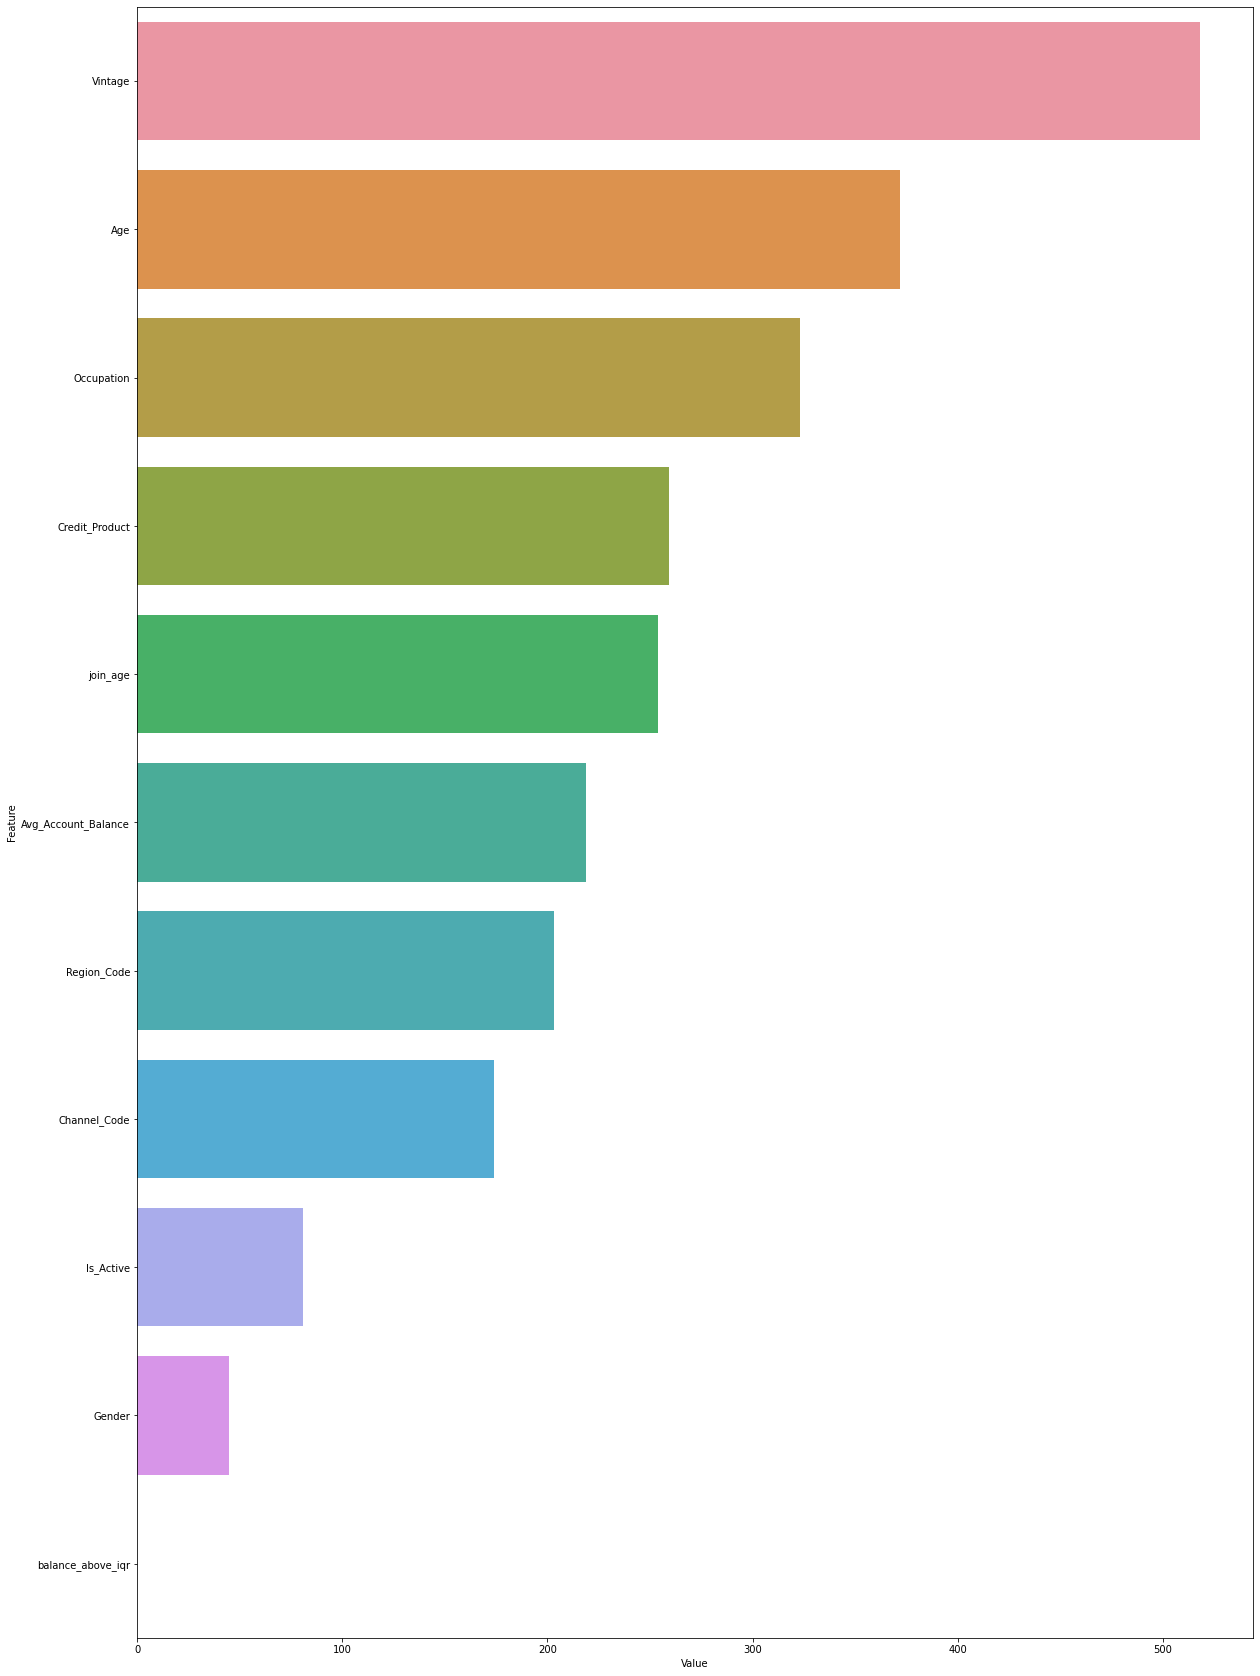

In [36]:
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,x_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))

In [37]:
pred = lgb.predict_proba(x_test)[:, 1]
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Is_Lead'] = pred
sub.to_csv("Sub_6.csv",index=False)